In [1]:

import numpy as np 
import pandas as pd 
import os
import cv2

## Labels

In [2]:
labels = os.listdir(r"archive/train")

In [3]:
labels

['no_yawn', 'Open', 'Closed', '.ipynb_checkpoints', 'yawn']

## Visualize A random image

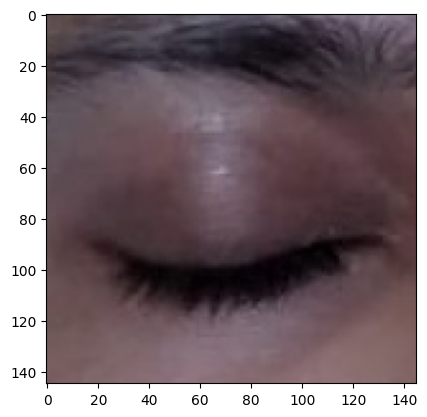

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"archive/train/Closed/_0.jpg"))

## Image array

In [5]:
a = plt.imread(r"archive/train/yawn/10.jpg")

## Image shape

In [6]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array) 


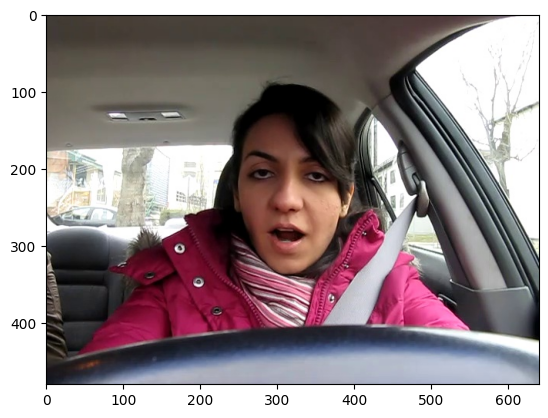

In [7]:
plt.imshow(plt.imread(r"archive/train/yawn/10.jpg"))

## Take only face(For yawn and not_yawn)

In [8]:
def face_for_yawn(direc=r"archive/train", face_cas_path=r"haarcascade_frontalface_default.xml"):#archive(1)\haarcascade_frontalface_default.xml
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [9]:
def get_data(dir_path=r"archive/train", face_cas=r"haarcascade_frontalface_default.xml", eye_cas=r"haarcascade.xml"):#archive(1)\haarcascade_frontalface_default.xml", eye_cas=r"archive(1)\haarcascade.xml
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [10]:
data_train = get_data()

2
3


## Extend data and Convert array

In [11]:
def append_data():
    #total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    #print(yaw_no)
    return (yaw_no)#np.array


## New variable to store

In [12]:
new_data = append_data()

0
1
2
3


# Separate label and features

In [13]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Label array

In [16]:
y = np.array(y)

## Train Test split

In [17]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [18]:
len(X_test)

578

## Import some dependencies

In [19]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2023-04-07 23:43:35.169535: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 23:43:35.209374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 23:43:35.210397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 23:43:37.102627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Augmentation

In [20]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [21]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [22]:
history = model.fit(train_generator, epochs=1, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

2023-04-07 23:43:40.282836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - ETA: 0s - loss: 1.2542 - accuracy: 0.4202

2023-04-07 23:44:41.227618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - 66s 2s/step - loss: 1.2542 - accuracy: 0.4202 - val_loss: 1.1176 - val_accuracy: 0.4723


## History

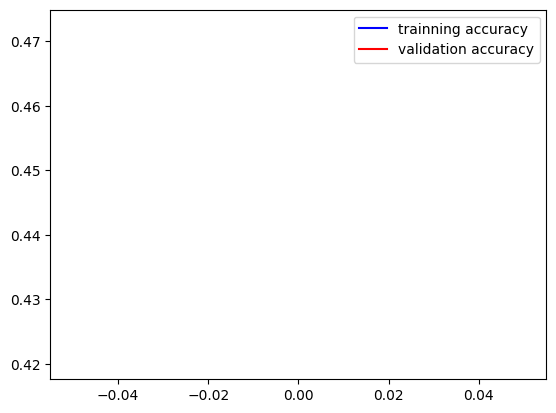

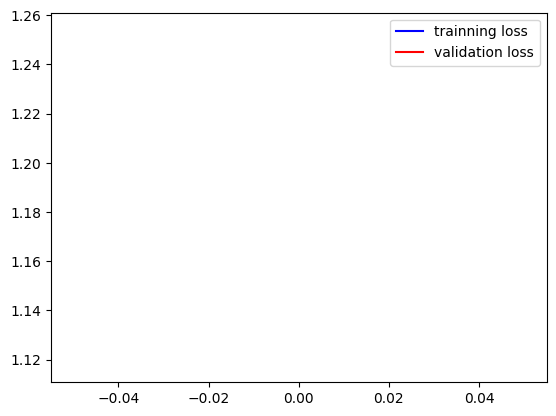

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [24]:
model.save("drowiness_new7.h5")

In [25]:
model.save("drowiness_new7.model")

2023-04-07 23:44:47.557406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1568]
	 [[{{node inputs}}]]
2023-04-07 23:44:48.016659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1568]
	 [[{{node inputs}}]]


# Prediction

In [26]:
prediction = (model.predict(X) > 0.5).astype("int32")

61/61 [==============================] - 18s 289ms/step


In [27]:
prediction

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]], dtype=int32)

# classification report

In [28]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [29]:
#from sklearn.metrics import classification_report
#print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

# predicting function

In [30]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas=r"haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("drowiness_new7.h5")#E:\drowsy eye\driver_drowsiness_system_CNN-main\drowiness_new7.h5

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [31]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare(r"archive/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 85ms/step


2

In [32]:
prediction = model.predict([prepare(r"archive/train/Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 36ms/step


2

In [33]:
prediction = model.predict([prepare(r"archive/train/Closed/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 31ms/step


2

In [34]:
prediction = model.predict([prepare(r"archive/train/yawn/12.jpg")])
np.argmax(prediction)


1/1 [==============================] - 0s 35ms/step


2